## Bitcoin Price Anomaly

In [52]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pickle

from sklearn.ensemble import IsolationForest

DATA_PATH = "../data/"
MODEL_PATH = "../model/"

In [53]:
# define a conversion function for the native timestamps in the csv file
def dateparse(unix_timestamp: float):
    return datetime.datetime.fromtimestamp(unix_timestamp) if not np.isnan(unix_timestamp) else np.nan

In [54]:
# Load dataset
df = pd.read_csv(DATA_PATH + "btcusd_1-min_data.csv") # read the csv data
df['Timestamp'] = df['Timestamp'].apply(dateparse) # apply convertion from unix timestamp to datetime
df.dropna(inplace=True)

In [8]:
# Select features relevant for anomaly detection (example features)
X = df[[
    'Low', 
    'High', 
    'Open', 
    'Close', 
    'Volume'
    ]]

In [9]:
# Initialize Isolation Forest model
iso_forest = IsolationForest(n_estimators=100,  # Number of trees in the forest
                             contamination=0.01,  # Proportion of outliers in the data
                             max_samples='auto',  # Subsample size for each tree
                             random_state=42)    # For reproducibility

# Fit the model to the data
iso_forest.fit(X)

IsolationForest(contamination=0.01, random_state=42)

In [10]:
# Predict anomaly scores (-1 for anomalies, 1 for normal data points)
anomaly_labels = iso_forest.predict(X)

# Add the anomaly labels to the original dataframe
df['anomaly'] = anomaly_labels

In [11]:
print(F"Normal Points: {len(df[df['anomaly'] == 1])}")
print(F"Anomaly Points: {len(df[df['anomaly'] == -1])}")

Normal Points: 6631298
Anomaly Points: 66982


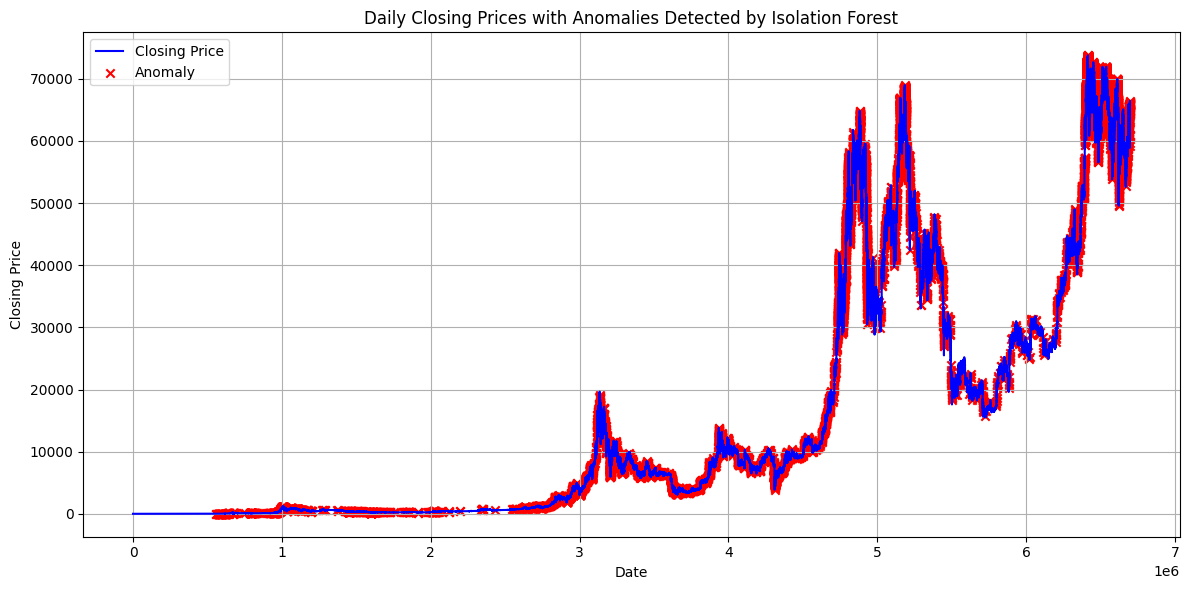

In [12]:
# Plot daily close prices with anomalies
plt.figure(figsize=(12, 6))

# Plot the daily close prices
plt.plot(df.index, df['Close'], label='Closing Price', color='blue')

# Highlight the anomalies
anomalies = df[df['anomaly'] == -1]  # Filter out anomaly points
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomaly', marker='x')

# Add labels and legend
plt.title('Daily Closing Prices with Anomalies Detected by Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

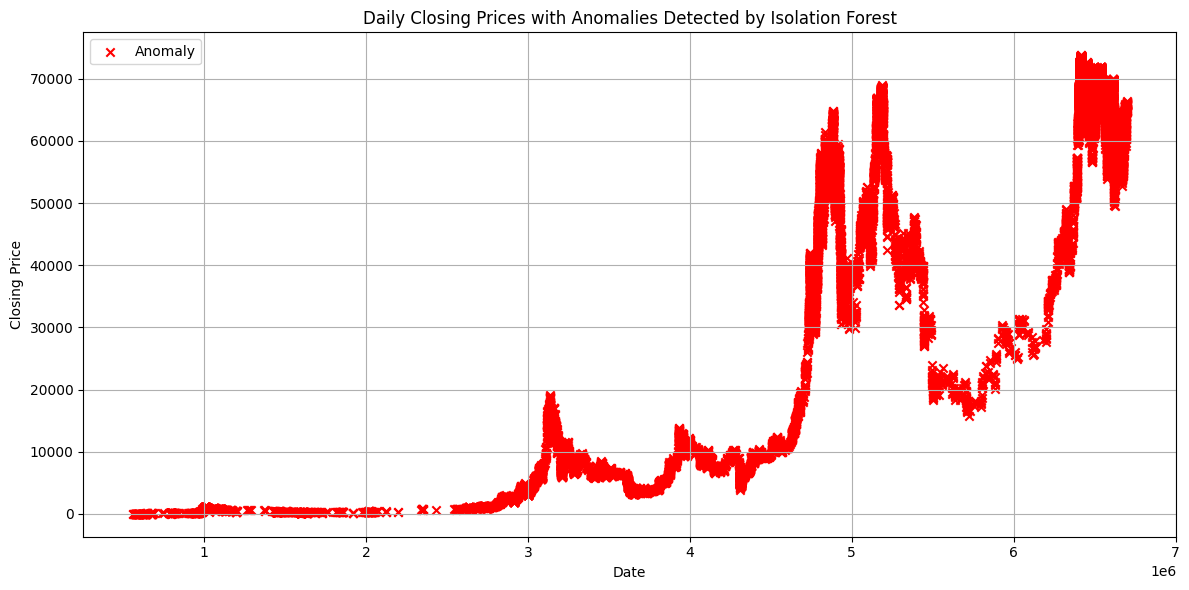

In [13]:
# Plot daily close prices with anomalies
plt.figure(figsize=(12, 6))

# Plot the daily close prices
plt.plot(df.index, df['Close'], label='Closing Price', color='blue')

# Highlight the anomalies
anomalies = df[df['anomaly'] == -1]  # Filter out anomaly points
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomaly', marker='x')

# Add labels and legend
plt.title('Daily Closing Prices with Anomalies Detected by Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="color: lightblue; font-size: 14px;">Comments:</span>

- There are too many points to interpret

### Reduced DF (3-years hourly grouped)

In [86]:
full_df = df.copy()

In [87]:
# created this function to analyse the short-term dataset
def filter_dataframe_by_year(df, years=3):
    # filter dataframe from 1 year from the last date
    last_date = df['Timestamp'].max() # get the last date
    one_year_ago = last_date - pd.DateOffset(years=years) # reduce 1 year from the last date
    df = df[df['Timestamp'] >= one_year_ago].copy() # filter dataframe from 1 year from the last date
    return df

df = filter_dataframe_by_year(df)
df.head(3)

,Timestamp,Open,High,Low,Close,Volume
5146859,2021-10-14 21:00:00,57877.42,57900.00,57823.93,57830.85,0.537921
5146860,2021-10-14 21:01:00,57840.56,57840.56,57758.42,57796.18,5.482174
5146861,2021-10-14 21:02:00,57796.18,57809.04,57773.64,57809.04,0.236859


Feature Engineering

In [88]:
# create price per unit correlation
epsilon = 1e-10  # Small value to prevent division by zero
df['price_per_unit'] = df['Close'].divide(df['Volume'].replace(0, epsilon), fill_value=0) # prevent inf value
df.tail(3)

# create variation between high and low values
df['high_low_variation'] = df['High'] - df['Low']# prevent inf value
df.tail(3)

# create variation between open and close values
df['open_close_variation'] = df['Close'] - df['Open'] # prevent inf value
df.tail(3)

,Timestamp,Open,High,Low,Close,Volume,price_per_unit,high_low_variation,open_close_variation
6698277,2024-10-14 20:58:00,66054.0,66062.0,66054.0,66062.0,0.005927,1.114515e+07,8.0,8.0
6698278,2024-10-14 20:59:00,66070.0,66070.0,66070.0,66070.0,0.000480,1.377664e+08,0.0,0.0
6698279,2024-10-14 21:00:00,66070.0,66118.0,66070.0,66098.0,0.483483,1.367121e+05,48.0,28.0


In [90]:
df.set_index('Timestamp', inplace=True)

df = df.resample('h').agg({
    'Low': 'mean',
    'High': 'mean',
    'Open': 'mean',
    'Close': 'mean',
    'Volume': 'mean',
    'price_per_unit': 'mean',
    'high_low_variation': 'mean',
    'open_close_variation': 'mean'
}).reset_index()

df.fillna(0, inplace=True)
df.head(3)

,Timestamp,Low,High,Open,Close,Volume,price_per_unit,high_low_variation,open_close_variation
0,2021-10-14 21:00:00,57546.940333,57592.613167,57573.931500,57567.744667,1.003775,1.903546e+06,45.672833,-6.186833
1,2021-10-14 22:00:00,57612.370500,57635.632667,57622.124667,57627.669333,1.154713,1.688791e+06,23.262167,5.544667
2,2021-10-14 23:00:00,57589.880833,57621.988500,57609.208000,57606.329667,0.419678,1.387484e+06,32.107667,-2.878333


In [91]:
len(df)

26305

In [92]:
# Select features relevant for anomaly detection (example features)
X = df[[
    'Low', 
    'High', 
    'Open', 
    'Close', 
    'Volume',
    'price_per_unit',
    'high_low_variation',
    'open_close_variation'
    ]]

# Initialize Isolation Forest model
iso_forest = IsolationForest(n_estimators=100,  # Number of trees in the forest
                             contamination=0.03,  # Proportion of outliers in the data
                             max_samples='auto',  # Subsample size for each tree
                             random_state=42)    # For reproducibility

# Fit the model to the data
iso_forest.fit(X)

# Predict anomaly scores (-1 for anomalies, 1 for normal data points)
anomaly_labels = iso_forest.predict(X)

# Add the anomaly labels to the original dataframe
df['anomaly'] = anomaly_labels

print(F"Normal Points: {len(df[df['anomaly'] == 1])}")
print(F"Anomaly Points: {len(df[df['anomaly'] == -1])}")

Normal Points: 25515
Anomaly Points: 790


In [93]:
anomalies = df[df['anomaly'] == -1]  # Filter out anomaly points
anomalies

,Timestamp,Low,High,Open,Close,Volume,price_per_unit,high_low_variation,open_close_variation,anomaly
6,2021-10-15 03:00:00,58177.082333,58292.763000,58224.732500,58257.498000,8.332989,1.011853e+06,115.680667,32.765500,-1
20,2021-10-15 17:00:00,60640.370167,60760.114000,60686.280500,60713.902500,11.079809,2.027854e+04,119.743833,27.622000,-1
89,2021-10-18 14:00:00,60932.777167,61063.257667,60991.521333,61012.973000,8.461131,1.458379e+04,130.480500,21.451667,-1
132,2021-10-20 09:00:00,64006.872333,64007.827500,64007.726500,64007.499000,0.031523,6.187401e+14,0.955167,-0.227500,-1
137,2021-10-20 14:00:00,64692.884833,64812.405833,64740.729333,64764.169667,7.607813,1.331959e+05,119.521000,23.440333,-1
...,...,...,...,...,...,...,...,...,...,...
26282,2024-10-13 23:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-1
26283,2024-10-14 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-1
26284,2024-10-14 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-1
26285,2024-10-14 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-1


In [94]:
full_df[
    (full_df['Timestamp'] >= '2024-10-14 00:00:00') & 
    (full_df['Timestamp'] <= '2024-10-14 04:30:00')
]

,Timestamp,Open,High,Low,Close,Volume
6697280,2024-10-14 04:21:00,64109.0,64114.0,64077.0,64077.0,0.244018
6697281,2024-10-14 04:22:00,64085.0,64103.0,64085.0,64103.0,0.005000
6697282,2024-10-14 04:23:00,64117.0,64119.0,64117.0,64119.0,0.008898
6697283,2024-10-14 04:24:00,64087.0,64087.0,64070.0,64070.0,0.006180
6697284,2024-10-14 04:25:00,64090.0,64090.0,64087.0,64087.0,0.006820
6697285,2024-10-14 04:26:00,64091.0,64091.0,64091.0,64091.0,0.000804
6697286,2024-10-14 04:27:00,64070.0,64076.0,64070.0,64076.0,0.005452
6697287,2024-10-14 04:28:00,64063.0,64063.0,64063.0,64063.0,0.005000
6697288,2024-10-14 04:29:00,64020.0,64028.0,64020.0,64023.0,0.041410
6697289,2024-10-14 04:30:00,64036.0,64044.0,64035.0,64044.0,0.006939


<span style="color: lightblue; font-size: 14px;">Comments:</span>

- There were not transactions between 00:00 and 04:00:00 in that day

Price

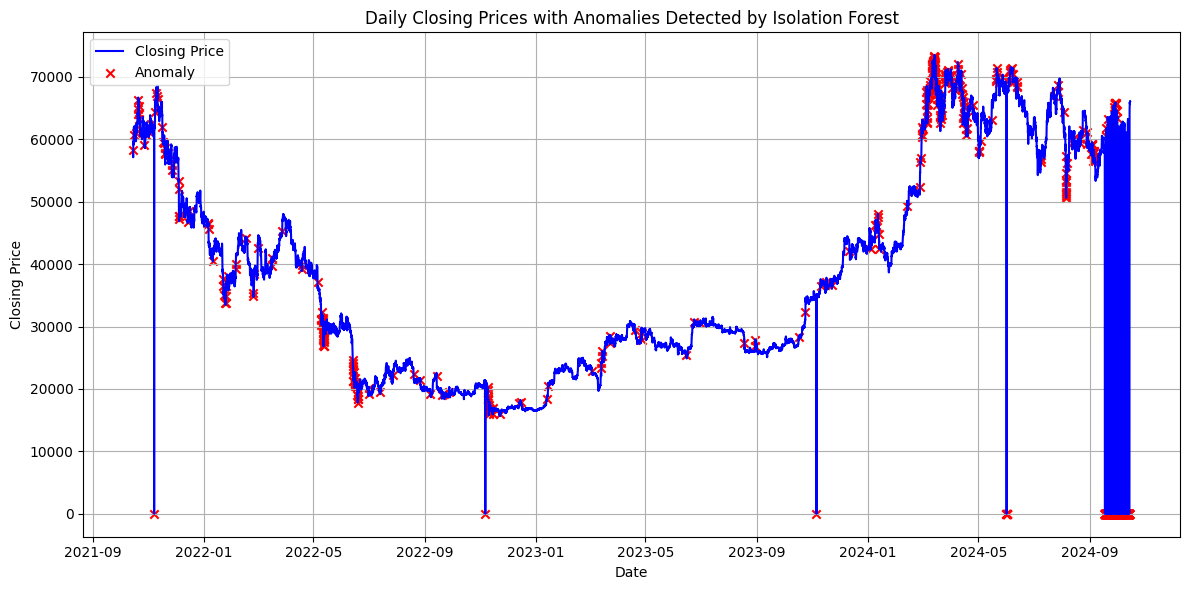

In [95]:
# Plot daily close prices with anomalies
plt.figure(figsize=(12, 6))

# Plot the daily close prices
plt.plot(df['Timestamp'], df['Close'], label='Closing Price', color='blue')

# Highlight the anomalies

plt.scatter(anomalies['Timestamp'], anomalies['Close'], color='red', label='Anomaly', marker='x')

# Plotting Actual vs Predicted Closing Prices
# Add labels and legend
plt.title('Daily Closing Prices with Anomalies Detected by Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="color: lightblue; font-size: 14px;">Comments:</span>

- We can see that it's capturing the spike points for up and down variations. It has also identified the valleys where is no transactions

Volume

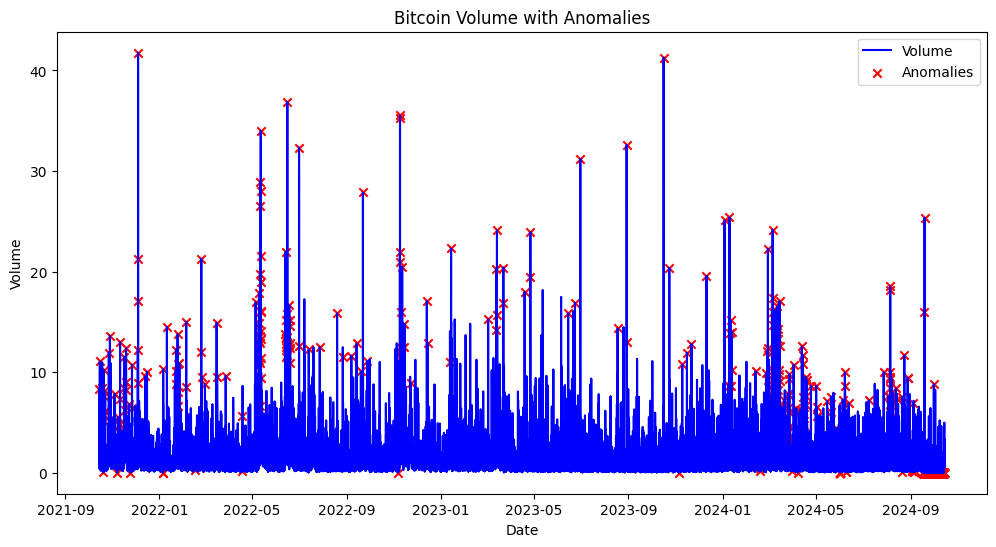

In [96]:
# Plot volume with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['Volume'], label='Volume', color='blue')
plt.scatter(anomalies['Timestamp'], anomalies['Volume'], color='red', label='Anomalies', marker='x')
plt.title('Bitcoin Volume with Anomalies')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

<span style="color: lightblue; font-size: 14px;">Comments:</span>

- It's also capturing up and down spikes in the volume of transactions as well, we can see that is covering all of the upspikes in the graph

High Low Var

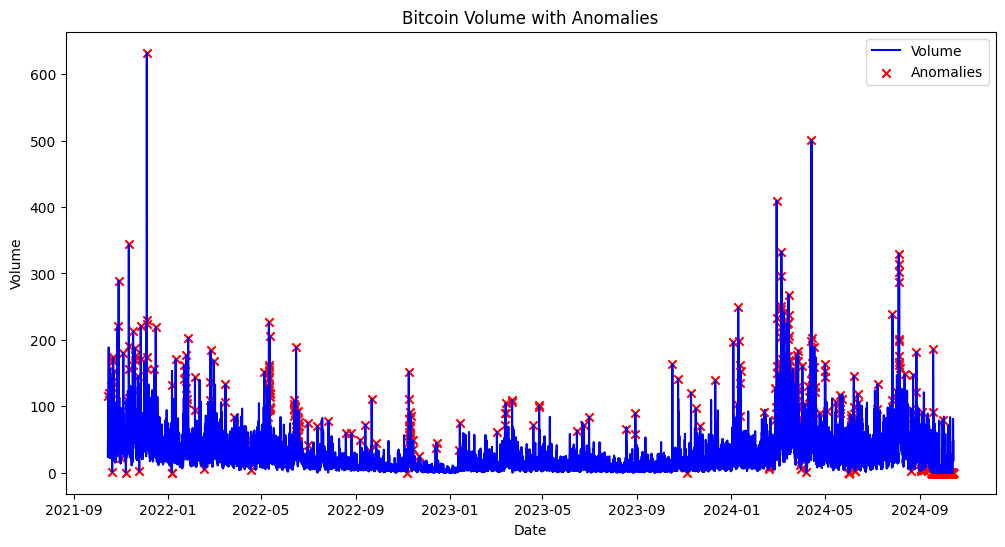

In [97]:
# Plot volume with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['high_low_variation'], label='Volume', color='blue')
plt.scatter(anomalies['Timestamp'], anomalies['high_low_variation'], color='red', label='Anomalies', marker='x')
plt.title('Bitcoin Volume with Anomalies')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

Open Close Var

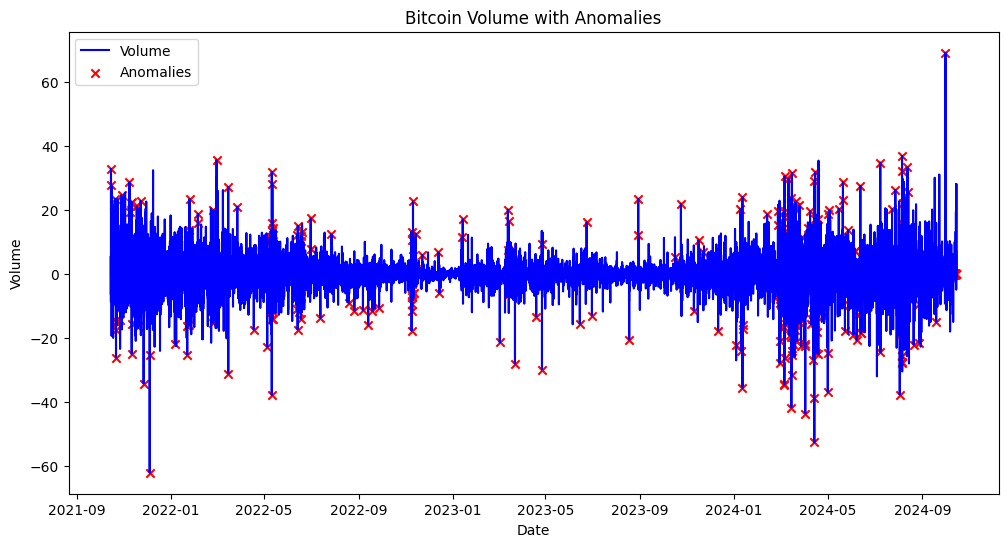

In [98]:
# Plot volume with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['open_close_variation'], label='Volume', color='blue')
plt.scatter(anomalies['Timestamp'], anomalies['open_close_variation'], color='red', label='Anomalies', marker='x')
plt.title('Bitcoin Volume with Anomalies')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

Price per Unit

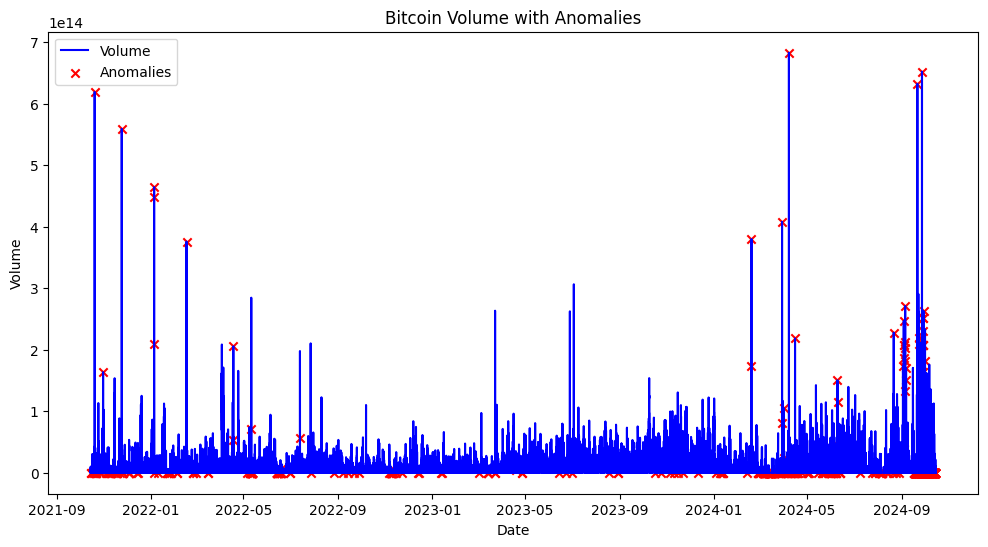

In [99]:
# Plot volume with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['price_per_unit'], label='Volume', color='blue')
plt.scatter(anomalies['Timestamp'], anomalies['price_per_unit'], color='red', label='Anomalies', marker='x')
plt.title('Bitcoin Volume with Anomalies')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

<span style="color: lightblue; font-size: 14px;">Comments:</span>

- The anomaly detection model could identify almost all of the outliers in all dimensions of the dataset

In [107]:
# Example Bitcoin dataset (make sure 'anomaly' is a column with 0/1 or True/False values)
df['anomaly'] = df['anomaly'].replace(-1, 0)

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df['Close'], 
    y=df['Volume'], 
    z=df['High'],
    mode='markers',
    marker=dict(
        size=5,
        color=df['anomaly'],  # Color the points based on anomaly status
        colorscale='Viridis',  # Choose a color scale
        opacity=0.8
    )
)])

# Update layout for axis labels
fig.update_layout(
    scene=dict(
        xaxis_title='Close Price',
        yaxis_title='Volume',
        zaxis_title='High Price'
    ),
    title='3D Interactive Scatter Plot of Bitcoin Data',
    width=800,
    height=700
)

# Show the interactive plot
fig.show()

In [73]:
# save the models
with open(MODEL_PATH + F'IsolationForest_Anomaly.pkl', 'wb') as f:
    pickle.dump(iso_forest, f)